In [1]:
import sklearn
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import scipy as scp
from scipy import sparse
from mvlearn.cluster.mv_spherical_kmeans import MultiviewSphericalKMeans

NUM_SAMPLES = 970 #All relevant class sizes range from 973 - 999

In [2]:
#A function to get the 20 newsgroup data
def get_data():

    #Load in the vectorized news group data from scikit-learn package
    news = fetch_20newsgroups(subset='all')
    all_data = np.array(news.data)
    all_targets = np.array(news.target)
    class_names = news.target_names

    #Set class pairings as described in the multiview clustering paper
    view1_classes = ['comp.graphics','rec.motorcycles', 'sci.space', 'rec.sport.hockey', 'comp.sys.ibm.pc.hardware']
    view2_classes = ['rec.autos', 'sci.med','misc.forsale', 'soc.religion.christian','comp.os.ms-windows.misc']
    
    #Create lists to hold data and labels for each of the 5 classes across 2 different views
    labels =  [num for num in range(len(view1_classes)) for _ in range(NUM_SAMPLES)]
    labels = np.array(labels)
    view1_data = list()
    view2_data = list()
    
    #Randomly sample 200 items from each of the selected classes in view1
    for ind in range(len(view1_classes)):
        class_num = class_names.index(view1_classes[ind])
        class_data = all_data[(all_targets == class_num)]
        print(class_data.shape)
        indices = np.random.choice(class_data.shape[0], NUM_SAMPLES)
        view1_data.append(class_data[indices])
    view1_data = np.concatenate(view1_data)
    
    #Randomly sample 200 items from each of the selected classes in view2
    for ind in range(len(view2_classes)):
        class_num = class_names.index(view2_classes[ind])
        class_data = all_data[(all_targets == class_num)]
        print(class_data.shape)
        indices = np.random.choice(class_data.shape[0], NUM_SAMPLES)
        view2_data.append(class_data[indices])  
    view2_data = np.concatenate(view2_data)
    
    #Vectorize the data
    vectorizer = TfidfVectorizer()
    view1_data = vectorizer.fit_transform(view1_data)
    view2_data = vectorizer.fit_transform(view2_data)

    #Shuffle and normalize vectors
    shuffled_inds = np.random.permutation(NUM_SAMPLES * len(view1_classes))
    view1_data = sparse.vstack(view1_data)
    view2_data = sparse.vstack(view2_data)
    view1_data = np.array(view1_data[shuffled_inds].todense())
    view2_data = np.array(view2_data[shuffled_inds].todense())
    magnitudes1 = np.linalg.norm(view1_data, axis=1)
    magnitudes2 = np.linalg.norm(view2_data, axis=1)
    magnitudes1[magnitudes1 == 0] = 1
    magnitudes2[magnitudes2 == 0] = 1
    magnitudes1 = magnitudes1.reshape((-1,1))
    magnitudes2 = magnitudes2.reshape((-1,1))
    view1_data /= magnitudes1
    view2_data /= magnitudes2
    labels = labels[shuffled_inds]

    return view1_data, view2_data, labels

In [3]:
v1_data, v2_data, labels = get_data()

(973,)
(996,)
(987,)
(999,)
(982,)
(990,)
(990,)
(975,)
(997,)
(985,)


In [4]:
def compute_entropy(partitions, labels, k, num_classes):
    
    total_entropy = 0
    num_examples = partitions.shape[0]
    for part in range(k):
        labs = labels[partitions == part]
        part_size = labs.shape[0]
        part_entropy = 0
        for cl in range(num_classes):
            prop = np.sum(labs == cl) * 1.0 / part_size
            ent = 0
            if(prop != 0):
                ent = - prop * np.log2(prop)
            part_entropy += ent
        part_entropy = part_entropy * part_size / num_examples
        total_entropy += part_entropy
    return total_entropy

In [5]:
def getEntropies(v1_data, v2_data, labels):
    
    entropies = list()
    for num in range(1,11):
        kmeans = MultiviewSphericalKMeans(n_clusters=num, init='random', n_init=1)
        pred = kmeans.fit_predict([v1_data, v2_data])
        ent = compute_entropy(pred, labels, num, 5)
        print(ent)
        entropies.append(ent)
    return entropies

def getSingleEntropies(v1_data, v2_data, labels):
    
    entropies = list()
    for num in range(1, 11):
        ent = single_spherical_kmeans([v1_data, v2_data], labels, num)
        entropies.append(ent)
        print(ent)
    return entropies

In [7]:
#Do spherical kmeans and get entropy values for each k for a single trial
num_trials = 1
mult_entropies = list()
for ind in range(num_trials):
    entropies = getEntropies(v1_data, v2_data, labels)
    mult_entropies.append(entropies)
mult_entropies = np.array(mult_entropies)
ave_m_entropies = np.mean(mult_entropies, axis=0)

2.321928094887362
1.4746424586299693
0.9107846293530779
0.5512260053709254
0.11535704858617243
0.11531166980791158
0.1288406448326965
0.11805954550887526
0.11117230002220092
0.12097291058892165


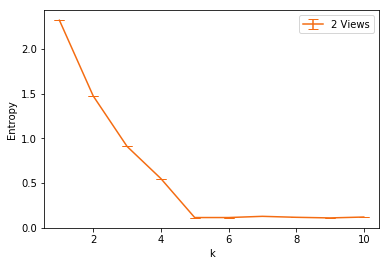

In [8]:
import matplotlib.pyplot as plt

mult_entropies = np.array(mult_entropies)
ave_m_entropies = np.mean(mult_entropies, axis=0)
std_m_entropies = np.std(mult_entropies, axis=0)
x_values = list(range(1, 11))
plt.errorbar(x_values, ave_m_entropies, std_m_entropies, capsize=5, color = '#F46C12')
plt.xlabel('k')
plt.ylabel('Entropy')
plt.legend(['2 Views'])
plt.rc('axes', labelsize=12)
plt.show()

In [9]:
#Do spherical kmeans and get entropy values for each k for multiple trials
num_trials = 20
mult_entropies = list()
for ind in range(num_trials):
    entropies = getEntropies(v1_data, v2_data, labels)
    mult_entropies.append(entropies)
mult_entropies = np.array(mult_entropies)
ave_m_entropies = np.mean(mult_entropies, axis=0)

2.321928094887362
1.7044714535188694
1.1209601389644077
0.5342901231971215
0.10971399479499348
0.09996337593542724
0.11198469239590488
0.10593753729068053
0.09176412901108663
0.10936839629124956
2.321928094887362
1.4746424586299693
0.949955359155097
0.4954857864046897
0.10469125175217499
0.11149989937047138
0.13233399661915288
0.09822634770522658
0.10027770181206615
0.12829902358564158
2.321928094887362
1.4746424586299693
0.9485955140598105
0.5378240458592062
0.5494316452347873
0.1173778505847627
0.09863730629276217
0.1251537463503982
0.0854731437909984
0.11321603862020667
2.321928094887362
1.705793727677869
1.120131657085283
0.5378240458592062
0.10848253892134625
0.10491631918604377
0.11554194759745971
0.09099411645822746
0.1133506897115128
0.11510813243010592
2.321928094887362
1.705793727677869
1.0622765596458557
0.556057978725293
0.499721770449283
0.10694071190164625
0.13335892843148406
0.10398638881141123
0.1517582665736731
0.09252698437585846
2.321928094887362
1.4746424586299693
1

KeyboardInterrupt: 

In [ ]:
mult_entropies = np.array(mult_entropies)
ave_m_entropies = np.mean(mult_entropies, axis=0)
std_m_entropies = np.std(mult_entropies, axis=0)
x_values = list(range(1, 11))
plt.errorbar(x_values, ave_m_entropies, std_m_entropies, capsize=5, color = '#F46C12')
plt.xlabel('k')
plt.ylabel('Entropy')
plt.legend(['2 Views'])
plt.rc('axes', labelsize=12)
plt.show()